## Gender Classification from Face Images Deep Learning

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


### Loading Seeds

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


### Dataset preparation

In [3]:
class FacecomGenderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for label, gender in enumerate(['male', 'female']):
            gender_folder = os.path.join(root_dir, gender)
            for fname in os.listdir(gender_folder):
                self.samples.append((os.path.join(gender_folder, fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


### Transform and dataloaders 

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = FacecomGenderDataset("data-set/Task_A/train", transform=train_transform)
val_dataset = FacecomGenderDataset("data-set/Task_A/val", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


### Model definition

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze backbone

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2)
)
model = model.to(device)


### Training setup

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


### Training loop

In [17]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.numpy())
    return preds, targets


### Evaluation function

In [21]:
def evaluate_model(model, dataloader, device, dataset_name="Validation"):
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    # Print classification report
    print(f"\nClassification Report ({dataset_name}):")
    print(classification_report(targets, preds, target_names=["male", "female"]))

    # Plot confusion matrix
    cm = confusion_matrix(targets, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["male", "female"], yticklabels=["male", "female"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.show()

    return preds, targets


### Training process
This code block is used to train the model. Run this block to train only otherwise avoid it.

In [19]:
best_acc = 0
patience = 3
wait = 0
EPOCHS = 20

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    preds, targets = evaluate(model, val_loader)
    acc = np.mean(np.array(preds) == np.array(targets))
    
    print(f"Train Loss: {train_loss:.4f} | Val Accuracy: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        wait = 0
        torch.save(model.state_dict(), "best_gender_model.pth")
        print("🔥 Best model saved!")
    else:
        wait += 1
        if wait >= patience:
            print("⏸️ Early stopping triggered.")
            break
    scheduler.step()



Epoch 1/20


100%|██████████| 61/61 [01:05<00:00,  1.07s/it]


Train Loss: 0.4066 | Val Accuracy: 0.8270
🔥 Best model saved!

Epoch 2/20


100%|██████████| 61/61 [00:28<00:00,  2.11it/s]


Train Loss: 0.2883 | Val Accuracy: 0.8791
🔥 Best model saved!

Epoch 3/20


100%|██████████| 61/61 [00:28<00:00,  2.15it/s]


Train Loss: 0.2403 | Val Accuracy: 0.9005
🔥 Best model saved!

Epoch 4/20


100%|██████████| 61/61 [00:27<00:00,  2.19it/s]


Train Loss: 0.2112 | Val Accuracy: 0.9028
🔥 Best model saved!

Epoch 5/20


100%|██████████| 61/61 [00:26<00:00,  2.27it/s]


Train Loss: 0.2146 | Val Accuracy: 0.9076
🔥 Best model saved!

Epoch 6/20


100%|██████████| 61/61 [00:31<00:00,  1.95it/s]


Train Loss: 0.1914 | Val Accuracy: 0.9076

Epoch 7/20


100%|██████████| 61/61 [00:27<00:00,  2.20it/s]


Train Loss: 0.2034 | Val Accuracy: 0.9100
🔥 Best model saved!

Epoch 8/20


100%|██████████| 61/61 [00:27<00:00,  2.21it/s]


Train Loss: 0.1935 | Val Accuracy: 0.9076

Epoch 9/20


100%|██████████| 61/61 [00:26<00:00,  2.26it/s]


Train Loss: 0.1907 | Val Accuracy: 0.9076

Epoch 10/20


100%|██████████| 61/61 [00:28<00:00,  2.12it/s]


Train Loss: 0.1938 | Val Accuracy: 0.9100
⏸️ Early stopping triggered.


### Evaluation
Training and validation evaluation charecteristics and confusion matrix

C:\Users\Sibsankar De\AppData\Local\Temp\ipykernel_30708\2020243275.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_gender_model.p


Classification Report (Validation):
              precision    recall  f1-score   support

        male       0.92      0.98      0.95       343
      female       0.86      0.62      0.72        79

    accuracy                           0.91       422
   macro avg       0.89      0.80      0.83       422
weighted avg       0.91      0.91      0.90       422



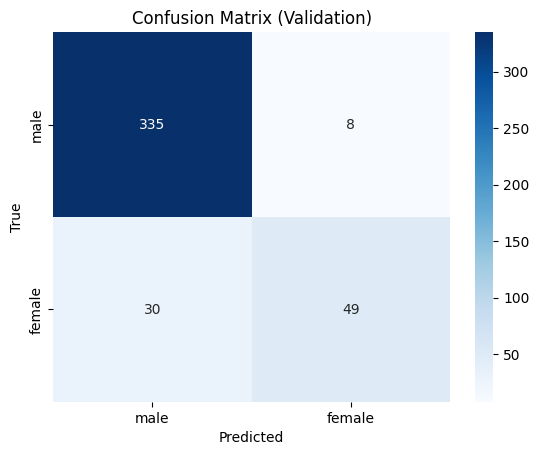


Classification Report (Training):
              precision    recall  f1-score   support

        male       0.94      0.97      0.95      1623
      female       0.82      0.64      0.72       303

    accuracy                           0.92      1926
   macro avg       0.88      0.81      0.84      1926
weighted avg       0.92      0.92      0.92      1926



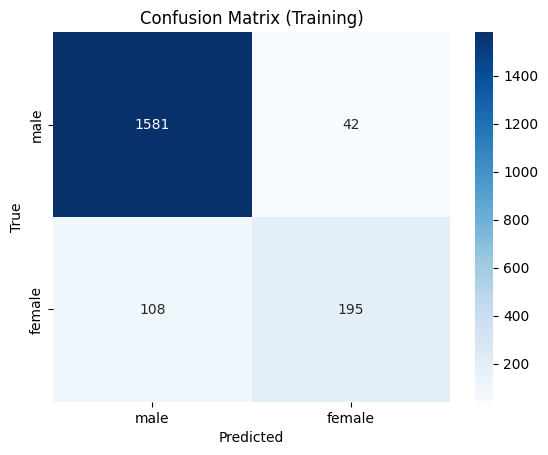

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("best_gender_model.pth"))
model.to(device)

val_preds, val_targets = evaluate_model(model, val_loader, device, "Validation")
train_preds, train_targets = evaluate_model(model, train_loader, device, "Training")

### Run this function with Image path to predict image details

In [24]:
def predict_image(model, image_path, transform, label_map, device):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Prepare model
    model.to(device)
    model.eval()

    with torch.no_grad():
        output = model(image)
        prob = torch.sigmoid(output).item()  # single sigmoid output
        pred = 1 if prob >= 0.5 else 0        # thresholding

    # Map class index to label (e.g., 0 → "male", 1 → "female")
    class_name = {v: k for k, v in label_map.items()}.get(pred, "Unknown")
    return class_name

### Example of usage this function - 

```bash
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

label_map = {"male": 0, "female": 1}
prediction = predict_image(model, "path/to/image.jpg", transform, label_map, device)
print("Predicted Gender:", prediction)
```